### **Final Project - Ilia Chanukvadze and Camilo Zuleta**

#### **Import packages**

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import datetime as dt
import pandas as pd    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.preprocessing import LabelEncoder
import datetime as dt
from scipy.stats import mstats
#!pip install xgboost
from xgboost import XGBRegressor
import statsmodels.api as sm

#### **Data extraction**

In [2]:
data = pd.read_csv('train.csv')
data.columns

Index(['ID', 'Price', 'Levy', 'Manufacturer', 'Model', 'Prod. year',
       'Category', 'Leather interior', 'Fuel type', 'Engine volume', 'Mileage',
       'Cylinders', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color',
       'Airbags'],
      dtype='object')

#### **Cleaning and data exploration**

In [3]:
# Data Exploration
print(data.head())
data.info()
data.describe()
print('Dataset size: ',str(data.shape[0]))


         ID  Price  Levy Manufacturer    Model  Prod. year   Category  \
0  45654403  13328  1399        LEXUS   RX 450        2010       Jeep   
1  44731507  16621  1018    CHEVROLET  Equinox        2011       Jeep   
2  45774419   8467     -        HONDA      FIT        2006  Hatchback   
3  45769185   3607   862         FORD   Escape        2011       Jeep   
4  45809263  11726   446        HONDA      FIT        2014  Hatchback   

  Leather interior Fuel type Engine volume    Mileage  Cylinders  \
0              Yes    Hybrid           3.5  186005 km        6.0   
1               No    Petrol             3  192000 km        6.0   
2               No    Petrol           1.3  200000 km        4.0   
3              Yes    Hybrid           2.5  168966 km        4.0   
4              Yes    Petrol           1.3   91901 km        4.0   

  Gear box type Drive wheels   Doors             Wheel   Color  Airbags  
0     Automatic          4x4  04-May        Left wheel  Silver       12  
1   

In [4]:
# Data Preprocessing
data.isnull().sum()
data.dropna(inplace=True)
print('Updated Dataset size: ',str(data.shape[0]))

# Data Cleaning
# Ensure the columns are of type string before using .str accessor
data['Mileage'] = data['Mileage'].astype(str)
data['Cylinders'] = data['Cylinders'].astype(str)
data['Engine volume'] = data['Engine volume'].astype(str)
data['Doors'] = data['Doors'].astype(str)
#data['Levy'] = data['Levy'].astype(str)

# Eliminate the km/h unit from the 'Speed' column and convert it to integer
data['Mileage'] = data['Mileage'].str.replace(' km', '', regex=True).astype(int)

# Take out the decimal from the columns Cylinders and convert it to integer
data['Cylinders'] = data['Cylinders'].str.replace('.0','')
data['Cylinders'] = data['Cylinders'].astype(int)

# Create a dummy variable to analyze if the engine has turbo or not
data['Turbo'] = data['Engine volume'].str.contains('Turbo')

# Eliminate non numerical words from Engine Volume column and convert it to float
data['Engine volume'] = data['Engine volume'].str.replace(' Turbo','')
data['Engine volume'] = data['Engine volume'].astype(float)

# Eliminate words from Doors column and convert it to integer
data['Doors'] = data['Doors'].str.replace('-May','')
data['Doors'] = data['Doors'].str.replace('-Mar','')
data['Doors'] = data['Doors'].str.replace('0','')
data['Doors'] = data['Doors'].replace('>5', '5')
data['Doors'] = data['Doors'].astype(int)

# Verify that the airbags variables is a number
data['Airbags'] = data['Airbags'].astype(int)

# Replace the '-' by the median in the Levy column, and turn it float variable
#data['Levy'] = data['Levy'].replace('-', np.nan)
#data['Levy'] = data['Levy'].astype(float)
#data['Levy'] = data['Levy'].fillna(data['Levy'].median())

# Change the production year by the age of the car
currt_time = dt.datetime.now()
data['Age'] = currt_time.year - data['Prod. year'] 

# Create dummies to categorical variable if columns exist
categorical_columns = ['Drive wheels', 'Gear box type', 'Fuel type', 'Leather interior']
existing_columns = [col for col in categorical_columns if col in data.columns]

if existing_columns:
	dummies = pd.get_dummies(data[existing_columns], prefix=['Drive', 'Gear', 'Fuel', 'Leather'])
	data = pd.concat([data, dummies], axis=1)

# Drop text unnecessary columns if they exist
columns_to_drop = ['Levy','Prod. year','ID', 'Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Wheel', 'Color']
existing_columns_to_drop = [col for col in columns_to_drop if col in data.columns]

if existing_columns_to_drop:
	data.drop(existing_columns_to_drop, axis=1, inplace=True)


data.head()


Updated Dataset size:  19237


,Price,Engine volume,Mileage,Cylinders,Doors,Airbags,Turbo,Age,Drive_4x4,Drive_Front,...,Gear_Variator,Fuel_CNG,Fuel_Diesel,Fuel_Hybrid,Fuel_Hydrogen,Fuel_LPG,Fuel_Petrol,Fuel_Plug-in Hybrid,Leather_No,Leather_Yes
0,13328,3.5,186005,6,4,12,False,15,True,False,...,False,False,False,True,False,False,False,False,False,True
1,16621,3.0,192000,6,4,8,False,14,True,False,...,False,False,False,False,False,False,True,False,True,False
2,8467,1.3,200000,4,4,2,False,19,False,True,...,True,False,False,False,False,False,True,False,True,False
3,3607,2.5,168966,4,4,0,False,14,True,False,...,False,False,False,True,False,False,False,False,False,True
4,11726,1.3,91901,4,4,4,False,11,False,True,...,False,False,False,False,False,False,True,False,False,True


#### **Correlations and outliers**

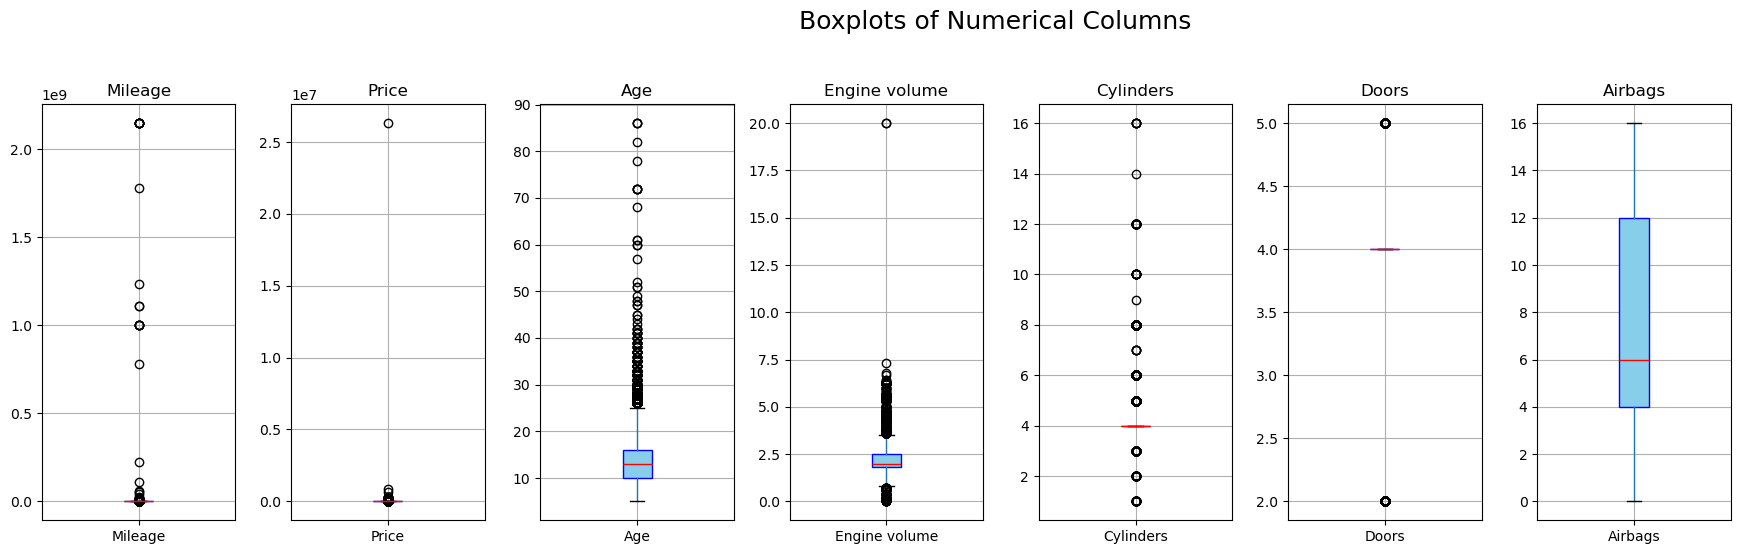

In [5]:
# Identifying the distribution of the numerical columns

numerical_columns = ['Mileage', 'Price', 'Age', 'Engine volume', 'Cylinders', 'Doors', 'Airbags']
plt.figure(figsize=(20, 10))
plt.suptitle('Boxplots of Numerical Columns', fontsize=18)
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 8, i)
    data.boxplot(column=col, patch_artist=True, boxprops=dict(facecolor='skyblue', color='blue'),
                 medianprops=dict(color='red'))
    plt.title(col, fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

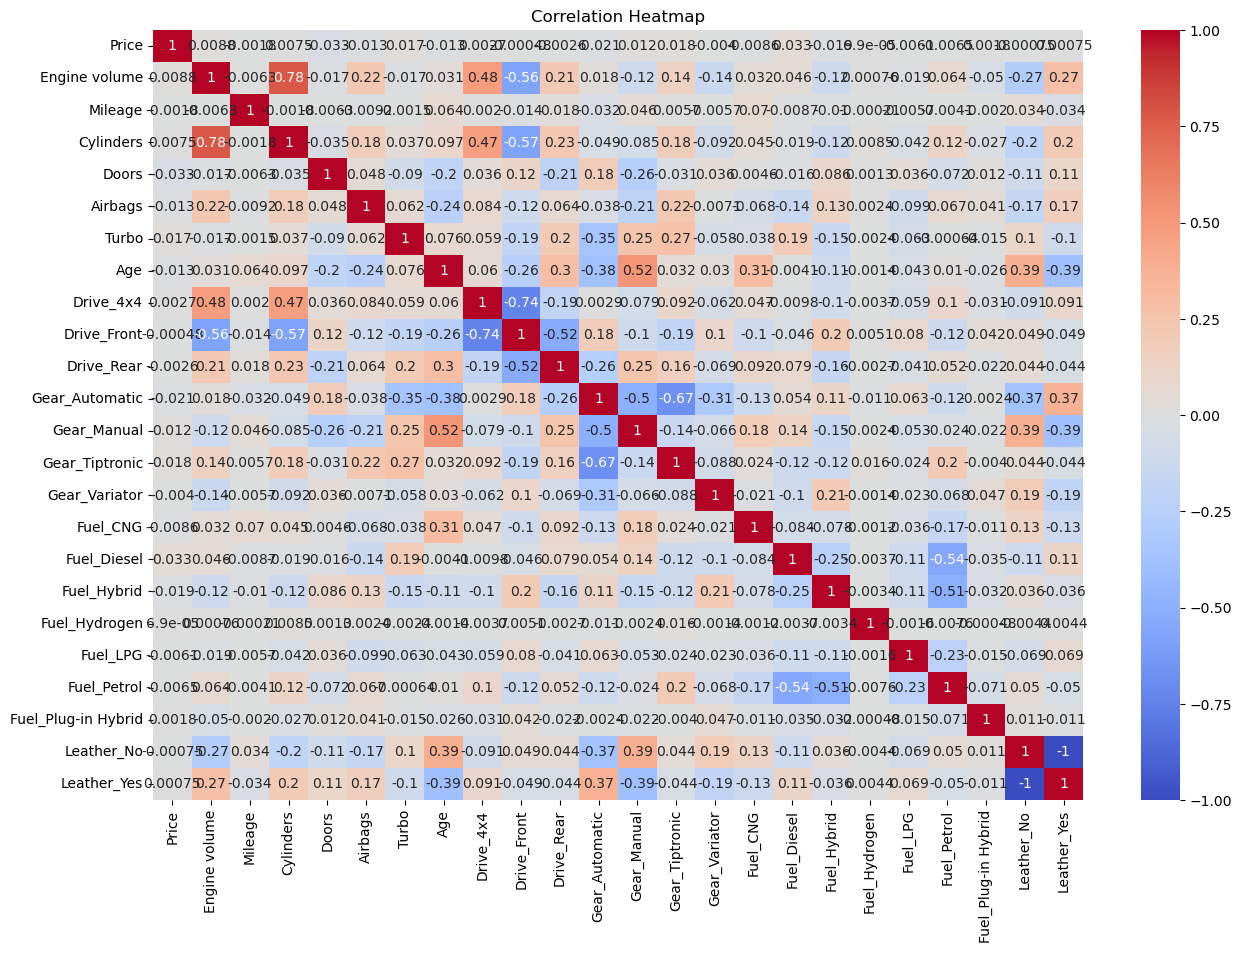

In [6]:
# COrrelation Heatmap
plt.figure(figsize=(15, 10))    
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap', fontsize=12)
plt.show()


In [7]:
# Handle outliers
# Outliers in the 'Price' column
data = data[(data["Price"] >= 1000) & (data["Price"] <= 100000)]

# Outliers in the 'Levy' column
#data = data[data['Levy'] < data['Price']]
#data['Levy_Percentage'] = (data['Levy'] / df['Price']) * 100
#data = data[data['Levy_Percentage'] <= 15]

# Outliers in the 'Mileage' column
data = data[data['Mileage'] <1e19 ]

# Outliers in the 'Engine volume' column
data = data[data['Engine volume'] <10 ]

# Outliers in the 'Age' column
data = data[data['Age'] <=60 ]

for col in numerical_columns[0:5]:
    data.loc[:, col] = mstats.winsorize(data[col], limits=[0.01, 0.04])

print('Updated Dataset size: ',str(data.shape[0]))

Updated Dataset size:  16542


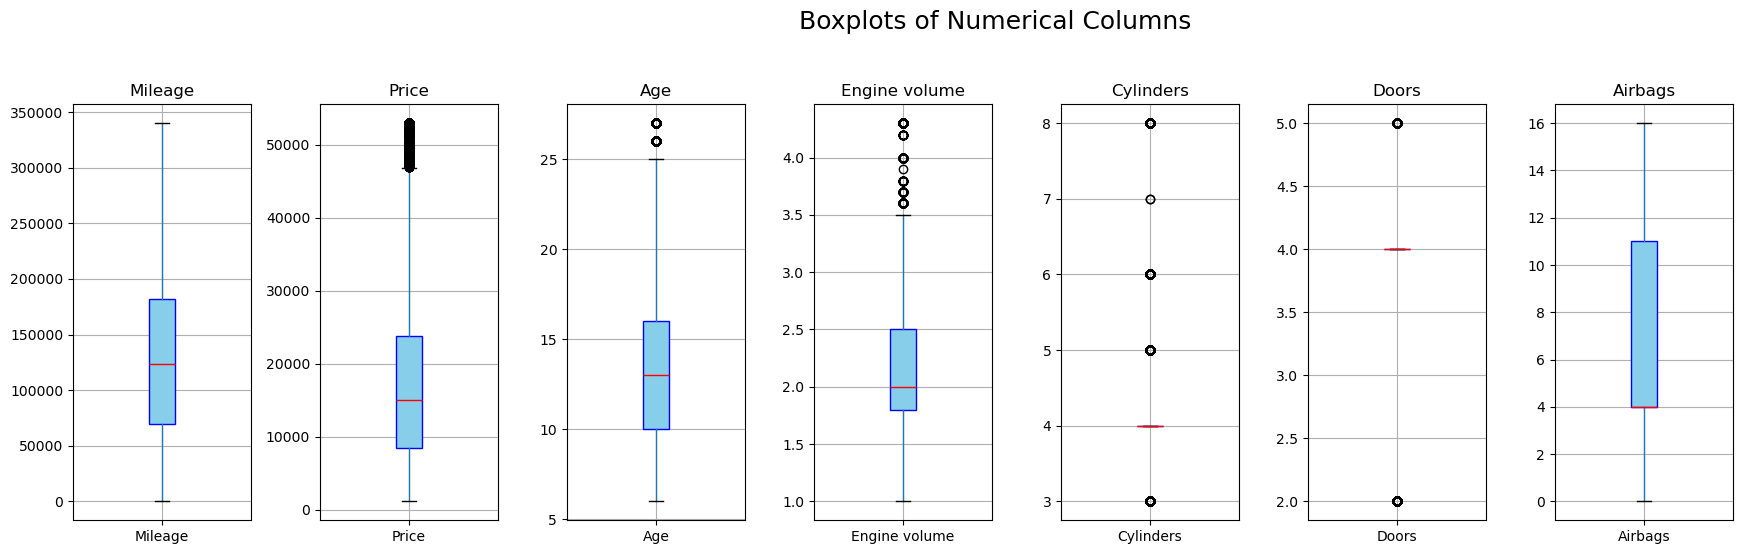

In [8]:
# Updated boxplots
plt.figure(figsize=(20, 10))
plt.suptitle('Boxplots of Numerical Columns', fontsize=18)
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 8, i)
    data.boxplot(column=col, patch_artist=True, boxprops=dict(facecolor='skyblue', color='blue'),
                 medianprops=dict(color='red'))
    plt.title(col, fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [9]:
# Label Encoding

label_encoder = LabelEncoder()
for col in data.select_dtypes(include=['object']).columns:
    data[col] = label_encoder.fit_transform(data[col])
data.info

<bound method DataFrame.info of        Price  Engine volume  Mileage  Cylinders  Doors  Airbags  Turbo  Age  \
0      13328            3.5   186005          6      4       12  False   15   
1      16621            3.0   192000          6      4        8  False   14   
2       8467            1.3   200000          4      4        2  False   19   
3       3607            2.5   168966          4      4        0  False   14   
4      11726            1.3    91901          4      4        4  False   11   
...      ...            ...      ...        ...    ...      ...    ...  ...   
19231   5802            3.5   107800          6      4       12  False   12   
19232   8467            2.0   300000          4      2        5   True   26   
19233  15681            2.4   161600          4      4        8  False   14   
19234  26108            2.0   116365          4      4        4  False   15   
19235   5331            2.0    51258          4      4        4  False   18   

       Drive_4x4  D

#### **Data splitting**

In [10]:
# Splitting the data into training, validation and testing sets
X = data.drop('Price', axis=1)
y = data['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)



#### **Baseline Model**

In [11]:
# Linear Regression
linear_reg = LinearRegression()
model= linear_reg.fit(X_train, y_train)
y_pred = linear_reg.predict(X_test)

MAE1=mean_absolute_error(y_test, y_pred)
MSE1=mean_squared_error(y_test, y_pred)
RMSE1=np.sqrt(mean_squared_error(y_test, y_pred))
R2_1=r2_score(y_test, y_pred)


print('Mean Absolute Error:', MAE1)
print('Mean Squared Error:', MSE1)
print('Root Mean Squared Error:',RMSE1)
print('R2 Score:', R2_1)



Mean Absolute Error: 8148.884760907366
Mean Squared Error: 112479254.50526373
Root Mean Squared Error: 10605.623720708922
R2 Score: 0.3546139521351932


#### **Model comparison**


In [12]:
# We will use the and Random Forest XGBoost Regressor models to predict the price of the cars
# We will use 10-fold cross-validation to tune the hyperparameters of the models

# Random Forest Regressor

random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

MAE2=mean_absolute_error(y_test, y_pred)
MSE2=mean_squared_error(y_test, y_pred)
RMSE2=np.sqrt(mean_squared_error(y_test, y_pred))
R2_2=r2_score(y_test, y_pred)


print('Mean Absolute Error:', MAE2)
print('Mean Squared Error:', MSE2)
print('Root Mean Squared Error:', RMSE2)
print('R2 Score:', R2_2)



Mean Absolute Error: 4009.822045304317
Mean Squared Error: 42090603.03902524
Root Mean Squared Error: 6487.727108859099
R2 Score: 0.7584915719162089


In [13]:
# XGBoost Regressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

MAE3=mean_absolute_error(y_test, y_pred)
MSE3=mean_squared_error(y_test, y_pred)
RMSE3=np.sqrt(mean_squared_error(y_test, y_pred))
R2_3=r2_score(y_test, y_pred)


print('Mean Absolute Error:', MAE3)
print('Mean Squared Error:', MSE3)
print('Root Mean Squared Error:', RMSE3)
print('R2 Score:', R2_3)




Mean Absolute Error: 4530.553793249191
Mean Squared Error: 45395411.97644279
Root Mean Squared Error: 6737.611741295486
R2 Score: 0.7395291633507397


In [14]:
# Model comparison
models = ['Linear Regression', 'Random Forest', 'XGBoost']
mae = [MAE1, MAE2, MAE3]
mse = [MSE1, MSE2, MSE3]
r2 = [R2_1, R2_2, R2_3]

model_comparison = pd.DataFrame({'Model': models, 'MAE': mae, 'MSE': mse, 'R2': r2})
print(model_comparison)
best_model=model_comparison[model_comparison['R2']==model_comparison['R2'].max()]['Model']
print('The best model is:',best_model.values[0])




               Model          MAE           MSE        R2
0  Linear Regression  8148.884761  1.124793e+08  0.354614
1      Random Forest  4009.822045  4.209060e+07  0.758492
2            XGBoost  4530.553793  4.539541e+07  0.739529
The best model is: Random Forest


#### **Hyperparameter tuning**

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Randomized Search Cross Validation for Random Forest

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


rf = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,  # Número de combinaciones aleatorias a probar
    cv=5,  # Menos costoso computacionalmente
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)


best_RS_RF=random_search.best_params_
best_score_RF=random_search.best_score_
best_estimator_RF=random_search.best_estimator_

print('Best parameters:',best_RS_RF)
print('Best score:', best_score_RF)
print('Best estimator:', best_estimator_RF)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   6.6s
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   6.6s
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   6.7s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   7.4s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   7.4s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   7.4s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   7.5s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   7.6s
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.7s
[CV] END max_depth=

In [16]:

# Randomized Search Cross Validation for Xgboost

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, 40, 50, None],
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'colsample_bylevel': [0.5, 0.7, 1.0],
    'colsample_bynode': [0.5, 0.7, 1.0],
    'gamma': [0, 1, 5]
}

xgb = XGBRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

best_RS_XGB=random_search.best_params_
best_score_XGB=random_search.best_score_
best_estimator_XGB=random_search.best_estimator_

print('Best parameters:', best_RS_XGB)
print('Best score:', best_score_XGB)
print('Best estimator:', random_search.best_estimator_)



Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END colsample_bylevel=0.5, colsample_bynode=0.5, colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=None, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bylevel=0.5, colsample_bynode=0.5, colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=None, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bylevel=0.5, colsample_bynode=0.5, colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=None, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bylevel=0.5, colsample_bynode=0.5, colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=None, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bylevel=0.5, colsample_bynode=0.5, colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=None, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bylevel=1.0, colsample_bynode=0.5, colsample_bytree=0.

In [17]:
# Compare the best Randomized models

best_models = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'Best Score': [best_score_RF, best_score_XGB]
})

print(best_models)
best_model=best_models[best_models['Best Score']==best_models['Best Score'].max()]['Model']
print('The best model is:',best_model.values[0])


           Model  Best Score
0  Random Forest    0.758529
1        XGBoost    0.765943
The best model is: XGBoost


#### **Best Model**

In [ ]:
# Save the best model
pickle.dump(best_model, open('model.pkl', 'wb'))